## 7-8 Putting it all together with a multi class classification problem
* Binary classification have 2 options
* Multiclass classification have more then 2 options

### Data preperation

Imports

In [ ]:
import torch as pt
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import helper_functions

Getting the data, then to tensors

In [ ]:
# Set the hyperparamaters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# To tensors
X_blob = pt.from_numpy(X_blob).type(pt.float)
y_blob = pt.from_numpy(y_blob).type(pt.float)

# Split to train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)



In [ ]:
y_blob, type(y_blob)

In [ ]:
# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

### Build model

In [54]:
device = "cuda" if pt.cuda.is_available() else "cpu"
pt.manual_seed(42)
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
# Create an instance of the model
model_4 = BlobModel(input_features=2, output_features=4).to(device)
print(model_4) # 2 pg av 2 dimensioner av blobbar, 4 för 4 st klasser

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [ ]:
# Create a loss function
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = pt.optim.SGD(params=model_4.parameters(), lr=0.1)

### Getting prediction probs to multi-class pytorch model 
När man använder multiclass classification ska man använda softmax istället för sigmoid, eftersom den konverterar till en där alla blir 1 och tar tanke på alla

In [ ]:
# Getting prediction probabilities for a multi class PyTorch model
# Raw outputs
model_4.eval()
with pt.inference_mode():
    y_test_logits = model_4(X_blob_test.to(device))
    y_pred_probs = pt.softmax(y_test_logits, dim=1)
    print(y_pred_probs[:10])
    print(pt.sum(y_pred_probs[0])) # sum av vald row blir 1

    print(pt.argmax(y_pred_probs[0]).item()) # för att finna den klassen som är mest sannolik att det är

In [ ]:
# Convert our model's prediction probabilities to prediction labels
y_preds = pt.argmax(y_pred_probs, dim=1)
print(y_preds)

### Train and Test Loop

In [56]:
y_blob_train.dtype

torch.float32

In [58]:
X_blob_train

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]])

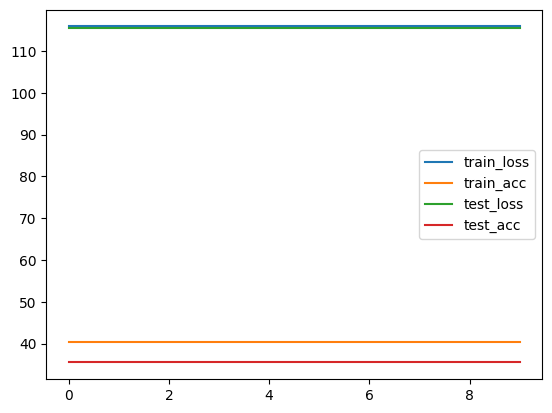

   train_loss  train_acc   test_loss  test_acc
0  115.882671     40.375  115.549076      35.5
1  115.882671     40.375  115.549076      35.5
2  115.882671     40.375  115.549076      35.5
3  115.882671     40.375  115.549076      35.5
4  115.882671     40.375  115.549076      35.5
5  115.882671     40.375  115.549076      35.5
6  115.882671     40.375  115.549076      35.5
7  115.882671     40.375  115.549076      35.5
8  115.882671     40.375  115.549076      35.5
9  115.882671     40.375  115.549076      35.5


In [57]:
### Create a training and testing loop for a multi-class pytorch model
from ml_funcs import progress_viewer 

pv = progress_viewer()

pt.manual_seed(42)
pt.cuda.manual_seed(42)

epochs = 10

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    train_logits = model_4(X_blob_train)
    train_pred_probs = pt.softmax(train_logits, dim=1)
    train_pred = train_pred_probs.argmax(dim=1)

    loss = loss_fn(train_logits, y_blob_train.type(pt.LongTensor))
    acc = helper_functions.accuracy_fn(y_blob_train, train_pred)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()
    with pt.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = pt.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test.type(pt.LongTensor))
        test_acc = helper_functions.accuracy_fn(y_blob_test, test_pred)
    pv.add(loss.item(),acc,test_loss.item(), test_acc)
pv.show()
print(pv.df)
    

### Visualization

In [ ]:
def view_results(X_train, y_train, X_test, y_test, model):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    helper_functions.plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1,2,2)
    plt.title("Test")
    helper_functions.plot_decision_boundary(model, X_test, y_test)

In [ ]:
view_results(X_blob_train, y_blob_train, X_blob_test, y_blob_test, model_4)

### load and save

In [ ]:
# save
from ml_funcs import save_model
save_model(model_4)

In [ ]:

#! load, testa sen

from ml_funcs import load_model
loaded_model = load_model(BlobModel,args_arr=[2,4])
print(loaded_model.state_dict())



### Evalutate

In [ ]:
# Make predictions
model_4.eval()
with pt.inference_mode():
    y_logits = model_4(X_blob_test)
    y_preds = pt.argmax(pt.softmax(y_logits, dim=1), dim=1)
    print(y_preds)

### A few more classification metrics
* Accuracy - how meny precent went right, bad for unbalenced scenarios
* Precision # for unbalanced
* Recall # for unbalanced
* F1-score # combination of 2 above
* Confusion matrix
* Classification report

extra: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

A lot of PyTorch metrics att TorchMetrics

In [ ]:
from torchmetrics import Accuracy

# Setup metric
tm_accuracy = Accuracy('multiclass', num_classes=4).to(device)
tm_accuracy(y_preds, y_blob_test).item()

### Exercises: 
https://www.learnpytorch.io/02_pytorch_classification/#exercises